## 使用TensorFlow做一个手机图像识别

In [1]:
import tensorflow as tf
from scipy.io import loadmat as load

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [3]:
train = load('/Users/elbert/Downloads/train_32x32.mat')

In [5]:
train['X'].shape
# 需要处理数据格式为（73257, 32, 32, 3）

(32, 32, 3, 73257)

In [6]:
train['y'].shape

(73257, 1)

In [7]:
train['y'][80:100]
# 数据中包含了‘10’，代表‘0’，应该预处理掉

array([[ 7],
       [ 3],
       [ 1],
       [ 2],
       [10],
       [ 4],
       [ 2],
       [ 2],
       [ 5],
       [ 1],
       [ 2],
       [ 9],
       [ 2],
       [10],
       [ 4],
       [ 1],
       [10],
       [ 3],
       [ 2],
       [ 7]], dtype=uint8)

In [8]:
test = load('/Users/elbert/Downloads/test_32x32.mat')
extra = load('/Users/elbert/Downloads/extra_32x32.mat')

In [9]:
extra.keys()

['y', 'X', '__version__', '__header__', '__globals__']

In [10]:
train_example = train['X']
test_example = test['X']
extra_example = extra['X']
train_label = train['y']
test_label = test['y']
extra_label = extra['y']

In [11]:
def reformat(samples, labels):
    samples = np.transpose(samples, (3, 0, 1, 2))
    labels = np.array([x[0] for x in labels])	# slow code, whatever
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0] * 10
        if num == 10:
            one_hot[0] = 1.0
        else:
            one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    labels = np.array(one_hot_labels).astype(np.float32)
    return samples, labels

In [12]:
train_example, train_label = reformat(train_example, train_label)

In [13]:
test_example, test_label = reformat(test_example, test_label)
extra_example, extra_label = reformat(extra_example, extra_label)

In [14]:
train_example.shape

(73257, 32, 32, 3)

In [15]:
def inspect(dataSet, label, i):
    print label[i]
    plt.imshow(dataSet[i])
    plt.show()

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


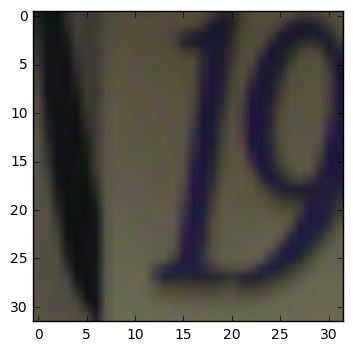

In [16]:
inspect(train_example, train_label, 0)

In [17]:
def normalize(samples):
    '''
    并且灰度化: 从三色通道 -> 单色通道     省内存 + 加快训练速度
    (R + G + B) / 3
    将图片从 0 ~ 255 线性映射到 -1.0 ~ +1.0
    @samples: numpy array
    '''
    a = np.add.reduce(samples, keepdims=True, axis=3)  # shape (图片数，图片高，图片宽，通道数)
    a = a/3.0
    return (a / 128) - 1.0
    

In [18]:
train_example = normalize(train_example)
test_example = normalize(test_example)
extra_example = normalize(extra_example)

In [26]:
num_labels = 10
image_size = 32
num_channels = 1

In [31]:
def get_chunk(samples, labels, chunkSize):
    '''
    Iterator/Generator: get a batch of data
    这个函数是一个迭代器/生成器，用于每一次只得到 chunkSize 这么多的数据
    用于 for loop， just like range() function
    '''
    if len(samples) != len(labels):
        raise Exception('Length of samples and labels must equal')
    stepStart = 0	# initial step
    i = 0
    while stepStart < len(samples):
        stepEnd = stepStart + chunkSize
        if stepEnd < len(samples):
            yield i, samples[stepStart:stepEnd], labels[stepStart:stepEnd]
            i += 1
        stepStart = stepEnd

In [52]:
# private function
def print_confusion_matrix(confusionMatrix):
    print('Confusion    Matrix:')
    for i, line in enumerate(confusionMatrix):
        print(line, line[i]/np.sum(line))
    a = 0
    for i, column in enumerate(np.transpose(confusionMatrix, (1, 0))):
        a += (column[i]/np.sum(column))*(np.sum(column)/26000)
        print(column[i]/np.sum(column),)
    print('\n',np.sum(confusionMatrix), a)

In [96]:
class Network:
    def __init__(self, num_hidden, batch_size, conv_depth, patch_size, pooling_scale):
        
        '''
        定义计算图谱
        @num_hidden    隐藏层节点数量
        @batch_size    为了节省内存，所以分批处理数据
        '''
        self.batch_size = batch_size
        self.num_hidden = num_hidden
        self.test_batch_size = 500
        
        self.patch_size = patch_size # 滑窗的大小
        self.conv1_depth = conv_depth
        self.conv2_depth = conv_depth
        self.conv3_depth = conv_depth
        self.conv4_depth = conv_depth
        self.last_conv_depth = self.conv4_depth
        self.pooling_scale = pooling_scale
        self.pooling_stride = self.pooling_scale# Max Pooling Stride
        
        self.graph = tf.Graph()
        self.tf_train_samples = None
        self.tf_train_labels = None
        self.tf_test_samples = None
        self.tf_test_labels = None
        self.tf_test_prediction = None
        
        # 统计
        self.merged = None
        self.train_summaries = []
        self.test_summaries = []
        
        #初始化
        self.define_gragh()
        self.session = tf.Session(graph=self.graph)
        self.writer = tf.summary.FileWriter('./board', self.graph)
                
        
    def define_gragh(self):
        '''定义计算图谱'''
        with self.graph.as_default():
            self.tf_train_samples = tf.placeholder(
                tf.float32,
                shape=(self.batch_size, image_size,
                       image_size, num_channels),
                name='tf_train_samples'
            )
            self.tf_train_labels = tf.placeholder(
                tf.float32,
                shape=(self.batch_size, num_labels),
                name='tf_train_labels'
            )
            self.tf_test_samples = tf.placeholder(
                tf.float32,
                shape=(self.test_batch_size,
                       image_size, image_size, num_channels),
                name='tf_test_samples'
            )
            
            with tf.name_scope('conv1'):
                conv1_weights = tf.Variable(
                    tf.truncated_normal([self.patch_size, self.patch_size, num_channels, self.conv1_depth], stddev=0.1))
                conv1_biases = tf.Variable(tf.zeros([self.conv1_depth]))
            with tf.name_scope('conv2'):
                conv2_weights = tf.Variable(
                    tf.truncated_normal([self.patch_size, self.patch_size, self.conv1_depth, self.conv2_depth], stddev=0.1))
                conv2_biases = tf.Variable(tf.constant(0.1, shape=[self.conv2_depth]))
            with tf.name_scope('conv3'):
                conv3_weights = tf.Variable(
                    tf.truncated_normal([self.patch_size, self.patch_size, self.conv2_depth, self.conv3_depth], stddev=0.1))
                conv3_biases = tf.Variable(tf.constant(0.1, shape=[self.conv3_depth]))
            with tf.name_scope('conv4'):
                conv4_weights = tf.Variable(
                    tf.truncated_normal([self.patch_size, self.patch_size, self.conv3_depth, self.conv4_depth], stddev=0.1))
                conv4_biases = tf.Variable(tf.constant(0.1, shape=[self.conv4_depth]))
            
            # fully connected layer 1, fully connected
            with tf.name_scope('fc1'):
                # because we do 2 times pooling of stride 2
                down_scale = self.pooling_scale ** 2
                fc1_weights = tf.Variable(
                    tf.truncated_normal(
                        [(image_size // down_scale) *
                         (image_size // down_scale) *
                         self.last_conv_depth, self.num_hidden],
                        stddev=0.1),
                    name='fc1_weights'
                )
                fc1_biases = tf.Variable(
                    tf.constant(0.1, shape=[self.num_hidden]),
                    name='fc1_biases'
                )
                self.train_summaries.append(tf.summary.histogram('fc1_weights', fc1_weights))
                self.train_summaries.append(tf.summary.histogram('fc1_biases', fc1_biases))

            # fully connected layer 2 --> output layer
            with tf.name_scope('fc2'):
                fc2_weights = tf.Variable(
                    tf.truncated_normal(
                        [self.num_hidden, num_labels], stddev=0.1
                    ),
                    name='fc2_weights'
                )
                fc2_biases = tf.Variable(
                    tf.constant(0.1, shape=[num_labels]),
                    name='fc2_biases'
                )
                self.train_summaries.append(tf.summary.histogram('fc2_weights', fc2_weights))
                self.train_summaries.append(tf.summary.histogram('fc2_biases', fc2_biases))
            
            # 现在来定义图谱的运算
            def model(data):
                
                with tf.name_scope('conv1_model'):
                    with tf.name_scope('convolution'):
                        conv1 = tf.nn.conv2d(data, filter=conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
                        addition = conv1 + conv1_biases
                    hidden = tf.nn.relu(addition)
                    
                    
                with tf.name_scope('conv2_model'):
                    with tf.name_scope('convolution'):
                        conv2 = tf.nn.conv2d(hidden, filter=conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
                        addition = conv2 + conv2_biases
                    hidden = tf.nn.relu(addition)
                    hidden = tf.nn.max_pool(
                        hidden,
                        ksize=[1,self.pooling_scale,self.pooling_scale,1],
                        strides=[1,self.pooling_stride,self.pooling_stride,1],
                        padding='SAME')
                    
                with tf.name_scope('conv3_model'):
                    with tf.name_scope('convolution'):
                        conv3 = tf.nn.conv2d(hidden, filter=conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
                        addition = conv3 + conv3_biases
                    hidden = tf.nn.relu(addition)

                with tf.name_scope('conv4_model'):
                    with tf.name_scope('convolution'):
                        conv4 = tf.nn.conv2d(hidden, filter=conv4_weights, strides=[1, 1, 1, 1], padding='SAME')
                        addition = conv4 + conv4_biases
                    hidden4 = tf.nn.relu(addition)
                    hidden4 = tf.nn.max_pool(
                        hidden,
                        ksize=[1,self.pooling_scale,self.pooling_scale,1],
                        strides=[1,self.pooling_stride,self.pooling_stride,1],
                        padding='SAME')
                
                # fully connected layer 1
                shape = hidden4.get_shape().as_list()
                print(data.get_shape(), shape)
                reshape = tf.reshape(data, [shape[0], shape[1] * shape[2] * shape[3]])
                print(reshape.get_shape(), fc1_weights.get_shape(), fc1_biases.get_shape())
                with tf.name_scope('fc1_model'):
                    fc1_model = tf.matmul(reshape, fc1_weights) + fc1_biases
                    hidden = tf.nn.relu(fc1_model)

                # fully connected layer 2
                with tf.name_scope('fc2_model'):
                    return tf.matmul(hidden, fc2_weights) + fc2_biases

            # Training computation.
            logits = model(self.tf_train_samples)
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.tf_train_labels)
                )
                self.train_summaries.append(tf.summary.scalar('Loss', self.loss))

            # Optimizer.
            with tf.name_scope('optimizer'):
                self.optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(self.loss)
            # Predictions for the training, validation, and test data.
            with tf.name_scope('predictions'):
                self.train_prediction = tf.nn.softmax(logits)
                self.test_prediction = tf.nn.softmax(model(self.tf_test_samples))
            
            self.merged = tf.summary.merge_all()
            self.merged_train_summary = tf.summary.merge(self.train_summaries)
            #self.merged_test_summary = tf.summary.merge(self.test_summaries)

        
    def run(self):
        '''
        用到session
        '''
        self.session = tf.Session(graph=self.graph)
        with self.session as session:
            tf.initialize_all_variables().run()

            ### 训练
            print('Start Training')
            # batch 1000
            for i, samples, labels in get_chunk(train_example,
                                                train_label,
                                                chunkSize=self.batch_size):
                _, l, predictions, summary = session.run(
                    [self.optimizer, self.loss, self.train_prediction, self.merged_train_summary],
                    feed_dict={self.tf_train_samples: samples, self.tf_train_labels: labels}
                )
                self.writer.add_summary(summary, i)
                # labels is True Labels
                accuracy, _ = self.accurancy(predictions, labels)
                if i % 50 == 0:
                    print('Minibatch loss at step %d: %f' % (i, l))
                    print('Minibatch accuracy: %.1f%%' % accuracy)
            ###

            ### 测试
            accuracies = []
            confusionMatrices = []
            for i, samples, labels in get_chunk(test_example, test_label, chunkSize=self.test_batch_size):
                result = self.test_prediction.eval(feed_dict={self.tf_test_samples: samples})
                accuracy, cm = self.accurancy(result, labels, need_confusion_matrix=True)
                accuracies.append(accuracy)
                confusionMatrices.append(cm)
                print('Test Accuracy: %.1f%%' % accuracy)
            print(' Average  Accuracy:', np.average(accuracies))
            print('Standard Deviation:', np.std(accuracies))
            print_confusion_matrix(np.add.reduce(confusionMatrices))
            ###
        
    def accurancy(self, predictions, labels, need_confusion_matrix=False):
        '''
        计算预测的正确率与召回率
        @return: accuracy and confusionMatrix as a tuple
        '''
        _predictions = np.argmax(predictions, 1)
        _labels = np.argmax(labels, 1)
        cm = confusion_matrix(_labels, _predictions) if need_confusion_matrix else None
        # == is overloaded for numpy array
        accuracy = (100.0 * np.sum(_predictions == _labels) / predictions.shape[0])
        return accuracy, cm
        


In [97]:
net = Network(num_hidden=16, batch_size=64, patch_size=3, conv_depth=16, pooling_scale=2)
net.run()

(TensorShape([Dimension(64), Dimension(32), Dimension(32), Dimension(1)]), [64, 8, 8, 16])
(TensorShape([Dimension(64), Dimension(1024)]), TensorShape([Dimension(1024), Dimension(16)]), TensorShape([Dimension(16)]))
(TensorShape([Dimension(500), Dimension(32), Dimension(32), Dimension(1)]), [500, 8, 8, 16])
(TensorShape([Dimension(500), Dimension(1024)]), TensorShape([Dimension(1024), Dimension(16)]), TensorShape([Dimension(16)]))
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Start Training
Minibatch loss at step 0: 2.333731
Minibatch accuracy: 9.4%
Minibatch loss at step 50: 2.392430
Minibatch accuracy: 4.7%
Minibatch loss at step 100: 2.351196
Minibatch accuracy: 9.4%
Minibatch loss at step 150: 2.414370
Minibatch accuracy: 1.6%
Minibatch loss at step 200: 2.370133
Minibatch accuracy: 4.7%
Minibatch loss at step 250: 2.381253
Minibatch accuracy: 7.8%
Minibatch loss at step 300: 2.351042
Minibatch accuracy: 6.2%
Minibatch loss at step 350: 2.336153
Minibatc

In [122]:
class Network2():
    def __init__(self, train_batch_size,
                 test_batch_size, pooling_scale, optimizeMethod='adam'):
        '''
        @num_hidden: 隐藏层的节点数量
        @batch_size：因为我们要节省内存，所以分批处理数据。每一批的数据量。
        '''
        self.optimizeMethod = optimizeMethod;

        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size

        # Hyper Parameters
        self.conv_config = [] # list of dict
        self.fc_config = [] # list of dict
        self.conv_weights = []
        self.conv_biases = []
        self.fc_weights = []
        self.fc_biases = []
        self.pooling_scale = pooling_scale
        self.pooling_stride = pooling_scale

        # Graph Related
        self.tf_train_samples = None
        self.tf_train_labels = None
        self.tf_test_samples = None
        self.tf_test_labels = None

        # 统计
        self.merged = None
        self.train_summaries = []
        self.test_summaries = []

    def add_conv(self, patch_size, in_depth, out_depth, activation='relu', pooling=False, name='conv'):
        '''
        This function does not define operations in the graph, but only store config in self.conv_layer_config
        '''
        self.conv_config.append({
            'patch_size': patch_size,
            'in_depth': in_depth,
            'out_depth': out_depth,
            'activation': activation,
            'pooling': pooling,
            'name': name
        })
        with tf.name_scope(name):
            weights = tf.Variable(
                tf.truncated_normal([patch_size, patch_size, in_depth, out_depth], stddev=0.1), name=name+'_weights')
            biases = tf.Variable(tf.constant(0.1, shape=[out_depth]), name=name+'_biases')
            self.conv_weights.append(weights)
            self.conv_biases.append(biases)

    def add_fc(self, in_num_nodes, out_num_nodes, activation='relu', name='fc'):
        '''
        add fc layer config to slef.fc_layer_config
        '''
        self.fc_config.append({
            'in_num_nodes': in_num_nodes,
            'out_num_nodes': out_num_nodes,
            'activation': activation,
            'name': name
        })
        with tf.name_scope(name):
            weights = tf.Variable(tf.truncated_normal([in_num_nodes, out_num_nodes], stddev=0.1))
            biases = tf.Variable(tf.constant(0.1, shape=[out_num_nodes]))
            self.fc_weights.append(weights)
            self.fc_biases.append(biases)
            self.train_summaries.append(tf.summary.histogram(str(len(self.fc_weights))+'_weights', weights))
            self.train_summaries.append(tf.summary.histogram(str(len(self.fc_biases))+'_biases', biases))

    def apply_regularization(self, _lambda):
        # L2 regularization for the fully connected parameters
        regularization = 0.0
        for weights, biases in zip(self.fc_weights, self.fc_biases):
            regularization += tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
        # 1e5
        return _lambda * regularization

    # should make the definition as an exposed API, instead of implemented in the function
    def define_inputs(self, train_samples_shape, train_labels_shape, test_samples_shape):
        # 这里只是定义图谱中的各种变量
        with tf.name_scope('inputs'):
            self.tf_train_samples = tf.placeholder(tf.float32, shape=train_samples_shape, name='tf_train_samples')
            self.tf_train_labels = tf.placeholder(tf.float32, shape=train_labels_shape, name='tf_train_labels')
            self.tf_test_samples = tf.placeholder(tf.float32, shape=test_samples_shape, name='tf_test_samples')

    def define_model(self):
        '''
        定义我的的计算图谱
        '''
        def model(data_flow, train=True):
            '''
            @data: original inputs
            @return: logits
            '''
            # Define Convolutional Layers
            for i, (weights, biases, config) in enumerate(zip(self.conv_weights, self.conv_biases, self.conv_config)):
                with tf.name_scope(config['name'] + '_model'):
                    with tf.name_scope('convolution'):
                        # default 1,1,1,1 stride and SAME padding
                        data_flow = tf.nn.conv2d(data_flow, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
                        data_flow = data_flow + biases
                        if not train:
                            self.visualize_filter_map(data_flow, how_many=config['out_depth'], display_size=32//(i//2+1), name=config['name']+'_conv')
                    if config['activation'] == 'relu':
                        data_flow = tf.nn.relu(data_flow)
                        if not train:
                            self.visualize_filter_map(data_flow, how_many=config['out_depth'], display_size=32//(i//2+1), name=config['name']+'_relu')
                    else:
                        raise Exception('Activation Func can only be Relu right now. You passed', config['activation'])
                    if config['pooling']:
                        data_flow = tf.nn.max_pool(
                            data_flow,
                            ksize=[1, self.pooling_scale, self.pooling_scale, 1],
                            strides=[1, self.pooling_stride, self.pooling_stride, 1],
                            padding='SAME')
                        if not train:
                            self.visualize_filter_map(data_flow, how_many=config['out_depth'], display_size=32//(i//2+1)//2, name=config['name']+'_pooling')

            # Define Fully Connected Layers
            for i, (weights, biases, config) in enumerate(zip(self.fc_weights, self.fc_biases, self.fc_config)):
                if i == 0:
                    shape = data_flow.get_shape().as_list()
                    data_flow = tf.reshape(data_flow, [shape[0], shape[1] * shape[2] * shape[3]])
                with tf.name_scope(config['name'] + 'model'):

                    ### Dropout
                    if train and i == len(self.fc_weights) - 1:
                        data_flow =  tf.nn.dropout(data_flow, 0.5, seed=4926)
                    ###

                    data_flow = tf.matmul(data_flow, weights) + biases
                    if config['activation'] == 'relu':
                        data_flow = tf.nn.relu(data_flow)
                    elif config['activation'] is None:
                        pass
                    else:
                        raise Exception('Activation Func can only be Relu or None right now. You passed', config['activation'])
            return data_flow

        # Training computation.
        logits = model(self.tf_train_samples)
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=self.tf_train_labels, logits=logits))
            self.loss += self.apply_regularization(_lambda=5e-4)
            self.train_summaries.append(tf.summary.scalar('Loss', self.loss))

        # learning rate decay
        global_step = tf.Variable(0)
        lr = 0.001
        dr = 0.99
        learning_rate = tf.train.exponential_decay(
            learning_rate=lr,
            global_step=global_step*self.train_batch_size,
            decay_steps=100,
            decay_rate=dr,
            staircase=True
        )

        # Optimizer.
        with tf.name_scope('optimizer'):
            if(self.optimizeMethod=='gradient'):
                self.optimizer = tf.train \
                    .GradientDescentOptimizer(learning_rate) \
                    .minimize(self.loss)
            elif(self.optimizeMethod=='momentum'):
                self.optimizer = tf.train \
                    .MomentumOptimizer(learning_rate, 0.5) \
                    .minimize(self.loss)
            elif(self.optimizeMethod=='adam'):
                self.optimizer = tf.train \
                    .AdamOptimizer(learning_rate) \
                    .minimize(self.loss)

        # Predictions for the training, validation, and test data.
        with tf.name_scope('train'):
            self.train_prediction = tf.nn.softmax(logits, name='train_prediction')
        with tf.name_scope('test'):
            self.test_prediction = tf.nn.softmax(model(self.tf_test_samples, train=False), name='test_prediction')

        self.merged_train_summary = tf.summary.merge(self.train_summaries)
        self.merged_test_summary = tf.summary.merge(self.test_summaries)

    def run(self, data_iterator, train_samples, train_labels, test_samples, test_labels):
        '''
        用到Session
        :data_iterator: a function that yields chuck of data
        '''
        # private function
        def print_confusion_matrix(confusionMatrix):
            print('Confusion    Matrix:')
            for i, line in enumerate(confusionMatrix):
                print(line, line[i] / np.sum(line))
            a = 0
            for i, column in enumerate(np.transpose(confusionMatrix, (1, 0))):
                a += (column[i] / np.sum(column)) * (np.sum(column) / 26000)
                print(column[i] / np.sum(column), )
            print('\n', np.sum(confusionMatrix), a)

        self.writer = tf.summary.FileWriter('./board', tf.get_default_graph())

        with tf.Session(graph=tf.get_default_graph()) as session:
            tf.initialize_all_variables().run()

            ### 训练
            print('Start Training ', self.train_batch_size)
            # batch 1000
            for i, samples, labels in data_iterator(train_samples, train_labels, chunkSize=self.train_batch_size):
                _, l, predictions, summary = session.run(
                    [self.optimizer, self.loss, self.train_prediction, self.merged_train_summary],
                    feed_dict={self.tf_train_samples: samples, self.tf_train_labels: labels}
                )
                self.writer.add_summary(summary, i)
                # labels is True Labels
                accuracy, _ = self.accuracy(predictions, labels)
                if i % 50 == 0:
                    print('Minibatch loss at step %d: %f' % (i, l))
                    print('Minibatch accuracy: %.1f%%' % accuracy)
            ###

            ### 测试
            accuracies = []
            confusionMatrices = []
            for i, samples, labels in data_iterator(test_samples, test_labels, chunkSize=self.test_batch_size):
                result, summary = session.run(
                    [self.test_prediction, self.merged_test_summary],
                    feed_dict={self.tf_test_samples: samples}
                )
                self.writer.add_summary(summary, i)
                accuracy, cm = self.accuracy(result, labels, need_confusion_matrix=True)
                accuracies.append(accuracy)
                confusionMatrices.append(cm)
                print('Test Accuracy: %.1f%%' % accuracy)
            print(' Average  Accuracy:', np.average(accuracies))
            print('Standard Deviation:', np.std(accuracies))
            print_confusion_matrix(np.add.reduce(confusionMatrices))
        ###

    def accuracy(self, predictions, labels, need_confusion_matrix=False):
        '''
        计算预测的正确率与召回率
        @return: accuracy and confusionMatrix as a tuple
        '''
        _predictions = np.argmax(predictions, 1)
        _labels = np.argmax(labels, 1)
        cm = confusion_matrix(_labels, _predictions) if need_confusion_matrix else None
        # == is overloaded for numpy array
        accuracy = (100.0 * np.sum(_predictions == _labels) / predictions.shape[0])
        return accuracy, cm

    def visualize_filter_map(self, tensor, how_many, display_size, name):
        print(tensor.get_shape)
        filter_map = tensor[-1]
        print(filter_map.get_shape())
        filter_map = tf.transpose(filter_map, perm=[2, 0, 1])
        print(filter_map.get_shape())
        filter_map = tf.reshape(filter_map, (how_many, display_size, display_size, 1))
        print(how_many)
        self.test_summaries.append(tf.summary.image(name, tensor=filter_map, max_outputs=how_many))

In [123]:
train_samples, train_labels = train_example, train_label
test_samples, test_labels = test_example, test_label

print('Training set', train_samples.shape, train_labels.shape)
print('    Test set', test_samples.shape, test_labels.shape)


def get_chunk(samples, labels, chunkSize):
    '''
    Iterator/Generator: get a batch of data
    这个函数是一个迭代器/生成器，用于每一次只得到 chunkSize 这么多的数据
    用于 for loop， just like range() function
    '''
    if len(samples) != len(labels):
        raise Exception('Length of samples and labels must equal')
    stepStart = 0  # initial step
    i = 0
    while stepStart < len(samples):
        stepEnd = stepStart + chunkSize
        if stepEnd < len(samples):
            yield i, samples[stepStart:stepEnd], labels[stepStart:stepEnd]
            i += 1
        stepStart = stepEnd


net = Network2(train_batch_size=64, test_batch_size=500, pooling_scale=2)
net.define_inputs(
        train_samples_shape=(64, image_size, image_size, num_channels),
        train_labels_shape=(64, num_labels),
        test_samples_shape=(500, image_size, image_size, num_channels)
    )
#
net.add_conv(patch_size=3, in_depth=num_channels, out_depth=16, activation='relu', pooling=False, name='conv1')
net.add_conv(patch_size=3, in_depth=16, out_depth=16, activation='relu', pooling=True, name='conv2')
net.add_conv(patch_size=3, in_depth=16, out_depth=16, activation='relu', pooling=False, name='conv3')
net.add_conv(patch_size=3, in_depth=16, out_depth=16, activation='relu', pooling=True, name='conv4')

# 4 = 两次 pooling, 每一次缩小为 1/2
# 16 = conv4 out_depth
net.add_fc(in_num_nodes=(image_size // 4) * (image_size // 4) * 16, out_num_nodes=16, activation='relu', name='fc1')
net.add_fc(in_num_nodes=16, out_num_nodes=10, activation=None, name='fc2')

net.define_model()
net.run(get_chunk, train_samples, train_labels, test_samples, test_labels)

('Training set', (73257, 32, 32, 1), (73257, 10))
('    Test set', (26032, 32, 32, 1), (26032, 10))
<bound method Tensor.get_shape of <tf.Tensor 'test_5/conv1_model/convolution/add:0' shape=(500, 32, 32, 16) dtype=float32>>
(32, 32, 16)
(16, 32, 32)
16
<bound method Tensor.get_shape of <tf.Tensor 'test_5/conv1_model/Relu:0' shape=(500, 32, 32, 16) dtype=float32>>
(32, 32, 16)
(16, 32, 32)
16
<bound method Tensor.get_shape of <tf.Tensor 'test_5/conv2_model/convolution/add:0' shape=(500, 32, 32, 16) dtype=float32>>
(32, 32, 16)
(16, 32, 32)
16
<bound method Tensor.get_shape of <tf.Tensor 'test_5/conv2_model/Relu:0' shape=(500, 32, 32, 16) dtype=float32>>
(32, 32, 16)
(16, 32, 32)
16
<bound method Tensor.get_shape of <tf.Tensor 'test_5/conv2_model/MaxPool:0' shape=(500, 16, 16, 16) dtype=float32>>
(16, 16, 16)
(16, 16, 16)
16
<bound method Tensor.get_shape of <tf.Tensor 'test_5/conv3_model/convolution/add:0' shape=(500, 16, 16, 16) dtype=float32>>
(16, 16, 16)
(16, 16, 16)
16
<bound metho